## Base Imports

In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")
import itertools

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
#     temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
#     temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
#     temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date
        agg_df[f'{env_type}-{week}_weeks_before_transfer-{function_name}'] = ph_df[before_transfer & condition]\
        .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})

    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_degree_days_aggregated_factor(ph_df, main_factor, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    days = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df['fw_cycle_length'] = days['diff']
    agg_df[f'{env_type}-transfer_feeding-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_transfer & after_vaccination].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-transfer_vaccination-degree_days'] = days['diff'] * degrees['mean']

    days = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')['event_date'] \
    .agg(['max','min'])
    days['diff'] = (days['max'] - days['min']).dt.days
    degrees = ph_df[before_vaccination & after_first_feeding].groupby('final_locus_population_id')[main_factor] \
    .agg(['mean'])
    agg_df[f'{env_type}-vaccination_feeding-degree_days'] = days['diff'] * degrees['mean']

    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date

        days = ph_df[before_transfer & condition].groupby('final_locus_population_id')['event_date'] \
        .agg(['max','min'])
        days['diff'] = (days['max'] - days['min']).dt.days
        degrees = ph_df[before_transfer & condition].groupby('final_locus_population_id')[main_factor] \
        .agg(['mean'])
        agg_df[f'{env_type}-{week}_weeks_before_transfer-degree_days'] = days['diff'] * degrees['mean']

#     mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
#     for col in agg_df.columns[:]:
#         agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
#         agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df


def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

def plot_swarm(df, factor, target, bins, y_scale=1):
    sns.set_style("whitegrid")

    arr_for_chart = df.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(df[factor], bins=bins)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100
    x_axis_factor = factor + '_binned'

    plt.figure()
    f, axs = plt.subplots(1, 1, figsize=(18,8), sharex=True)
    box_plot = sns.swarmplot(data=arr_for_chart, x=x_axis_factor, y=target)

    mean_target = arr_for_chart.groupby(x_axis_factor)[target].mean()
    mean_main_factor = arr_for_chart.groupby(x_axis_factor)[factor].mean()

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,
                      mean_target.iloc[xtick],
                      round(mean_target.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='black',
                      weight='semibold')
        box_plot.text(xtick,
                      mean_main_factor.iloc[xtick] / y_scale,
                      round(mean_main_factor.iloc[xtick], 2),
                      horizontalalignment='center',
                      size='xx-large',
                      color='darkblue',
                      weight='semibold')
    
    plt.title(f'Swarmplot: {target} vs. {factor}')
    axs.legend(
        arr_for_chart[x_axis_factor].value_counts().sort_index().apply(lambda x: 'Sample count: ' + str(x)),
        loc='upper right'
    )

    f.show()

#     f.savefig(f'swarmplot_{target}_vs_{factor}.jpg')

In [3]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/FW_temperature_cleared.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='../data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='../data/lw_alldates_final_locus.csv',
                       mortality_path='../data/smolt_dataset_transfers_until2023Feb28_narrow.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

tgc = pd.read_csv('../data/transfers_until2023Feb28_with_sw_growth_targets.csv')
vaccines = pd.read_csv('../data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = vaccines.groupby('FINAL_LOCUS_POPULATION_ID')[['VAC_EVENT_DATE', 'VAC_WEIGHT']].mean(numeric_only=False)
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

In [4]:
tempearture_mean = pd.DataFrame(temperature.groupby('final_locus_population_id')['temperature_cleared'].mean())\
.rename(columns={'temperature_cleared':'temperature_mean'})

temperature = temperature.merge(tempearture_mean,
                  left_on='final_locus_population_id', 
                  right_index=True)

## Feed Data

### Factors on FLP level

In [5]:
fw_mortality = pd.read_csv('fw_mortality_final_lp_grouped_upd.csv')
fw_mortality['event_date'] = pd.to_datetime(fw_mortality['event_date'])
fw_mortality = fw_mortality.merge(vaccines_agg, left_on='final_locus_population_id', right_index=True, how='left')
fw_mortality = fw_mortality.merge(fresh_water_dates, on='final_locus_population_id', how='left')

#### TS factors

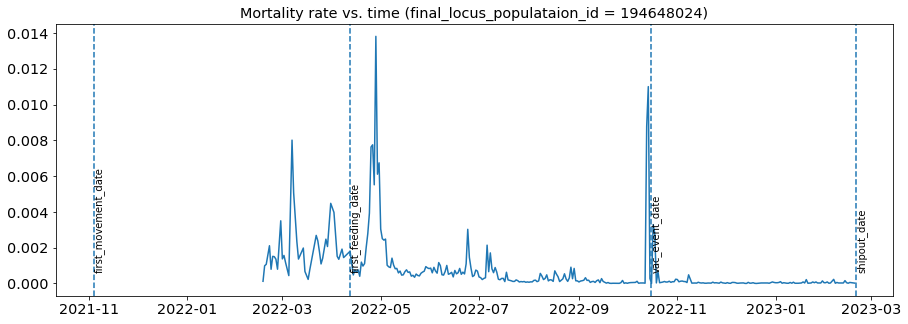

In [6]:
plt.plot(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['event_date'],
    fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['mortality_rate']
)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['first_movement_date'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['first_movement_date'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['mortality_rate'].mean(),
         f'first_movement_date',
         rotation=90)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['first_feeding_date'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['first_feeding_date'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['mortality_rate'].mean(),
         f'first_feeding_date',
         rotation=90)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['VAC_EVENT_DATE'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['VAC_EVENT_DATE'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['mortality_rate'].mean(),
         f'vac_event_date',
         rotation=90)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['shipout_date'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['shipout_date'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194648024]['mortality_rate'].mean(),
         f'shipout_date',
         rotation=90)
plt.title('Mortality rate vs. time (final_locus_populataion_id = 194648024)')
plt.savefig('./img/mortality_ts_analysis_flp_194648024.jpg')

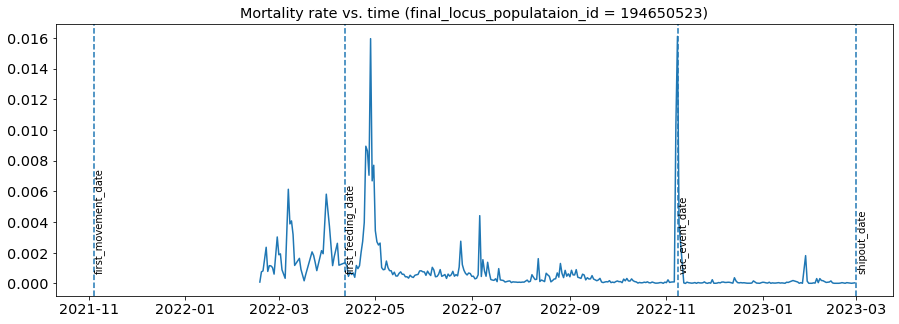

In [7]:
plt.plot(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['event_date'],
    fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['mortality_rate']
)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['first_movement_date'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['first_movement_date'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['mortality_rate'].mean(),
         f'first_movement_date',
         rotation=90)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['first_feeding_date'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['first_feeding_date'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['mortality_rate'].mean(),
         f'first_feeding_date',
         rotation=90)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['VAC_EVENT_DATE'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['VAC_EVENT_DATE'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['mortality_rate'].mean(),
         f'vac_event_date',
         rotation=90)

plt.axvline(
    fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['shipout_date'].mean(),
    linestyle='--'
)
plt.text(fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['shipout_date'].mean(),
         fw_mortality[fw_mortality['final_locus_population_id'] == 194650523]['mortality_rate'].mean(),
         f'shipout_date',
         rotation=90)
plt.title('Mortality rate vs. time (final_locus_populataion_id = 194650523)')

plt.savefig('./img/mortality_ts_analysis_flp_194650523.jpg')

In [8]:
before_ff_period, after_ff_period = 6 * 7, 4 * 7  # selected empirically (days)
before_vac_period, after_vac_period = 1 * 7, 1 * 7

before_ff_sum = fw_mortality[
    fw_mortality['event_date'].between(
        fw_mortality['first_feeding_date'] - pd.to_timedelta(before_ff_period, unit='D'),
        fw_mortality['first_feeding_date']
    )
].groupby('final_locus_population_id')['mortality_rate'].sum().reset_index()\
.rename(columns={'mortality_rate': 'mortality_rate_before_first_feeding_sum'})

after_ff_sum = fw_mortality[
    fw_mortality['event_date'].between(
        fw_mortality['first_feeding_date'],
        fw_mortality['first_feeding_date'] + pd.to_timedelta(after_ff_period, unit='D')
    )
].groupby('final_locus_population_id')['mortality_rate'].sum().reset_index()\
.rename(columns={'mortality_rate': 'mortality_rate_after_first_feeding_sum'})

before_vac_sum = fw_mortality[
    fw_mortality['event_date'].between(
        fw_mortality['VAC_EVENT_DATE'] - pd.to_timedelta(before_vac_period, unit='D'),
        fw_mortality['VAC_EVENT_DATE']
    )
].groupby('final_locus_population_id')['mortality_rate'].sum().reset_index()\
.rename(columns={'mortality_rate': 'mortality_rate_before_vaccination_sum'})

after_vac_sum = fw_mortality[
    fw_mortality['event_date'].between(
        fw_mortality['VAC_EVENT_DATE'],
        fw_mortality['VAC_EVENT_DATE'] + pd.to_timedelta(after_vac_period, unit='D')
    )
].groupby('final_locus_population_id')['mortality_rate'].sum().reset_index()\
.rename(columns={'mortality_rate': 'mortality_rate_after_vaccination_sum'})

vac_sum = before_vac_sum.merge(after_vac_sum, on='final_locus_population_id', how='inner')
vac_sum['mortality_rate_before_after_vaccination_sum'] = vac_sum['mortality_rate_before_vaccination_sum'] + \
vac_sum['mortality_rate_after_vaccination_sum']

In [9]:
fw_mortality = fw_mortality.merge(before_ff_sum, on='final_locus_population_id', how='inner')
display('Shape after merge:', fw_mortality.shape)
fw_mortality = fw_mortality.merge(after_ff_sum, on='final_locus_population_id', how='inner')
display('Shape after merge:', fw_mortality.shape)
fw_mortality = fw_mortality.merge(vac_sum, on='final_locus_population_id', how='inner')
display('Shape after merge:', fw_mortality.shape)

'Shape after merge:'

(1085032, 10)

'Shape after merge:'

(1085032, 11)

'Shape after merge:'

(967923, 14)

In [10]:
fw_mortality.head()

,final_locus_population_id,event_date,mortality_rate,VAC_EVENT_DATE,VAC_WEIGHT,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date,mortality_rate_before_first_feeding_sum,mortality_rate_after_first_feeding_sum,mortality_rate_before_vaccination_sum,mortality_rate_after_vaccination_sum,mortality_rate_before_after_vaccination_sum
0,36778733,2016-10-14,0.000168,2017-07-11,81.447124,3051009,2016-05-19,2016-12-22,2017-09-05,0.014725,0.077566,0.002187,0.001849,0.004036
1,36778733,2016-10-15,0.000121,2017-07-11,81.447124,3051009,2016-05-19,2016-12-22,2017-09-05,0.014725,0.077566,0.002187,0.001849,0.004036
2,36778733,2016-10-17,0.000995,2017-07-11,81.447124,3051009,2016-05-19,2016-12-22,2017-09-05,0.014725,0.077566,0.002187,0.001849,0.004036
3,36778733,2016-10-22,0.000104,2017-07-11,81.447124,3051009,2016-05-19,2016-12-22,2017-09-05,0.014725,0.077566,0.002187,0.001849,0.004036
4,36778733,2016-10-23,0.000170,2017-07-11,81.447124,3051009,2016-05-19,2016-12-22,2017-09-05,0.014725,0.077566,0.002187,0.001849,0.004036


In [11]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [12]:
fw_mortality_locus = fw_mortality.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='inner')

factors = ['mortality_rate_after_first_feeding_sum',
           'mortality_rate_before_first_feeding_sum',
           'mortality_rate_before_vaccination_sum',
           'mortality_rate_after_vaccination_sum',
           'mortality_rate_before_after_vaccination_sum']

key_columns = ['locus_id','fish_group_id','transfer_year']

fw_mortality_factors = create_factors_df(fw_mortality_locus,
                                     factors,
                                     key_columns, 
                                     weight_column='from_count_stocking',
                                     weighted_func=weighted_avg)

fw_mortality_factors = fw_mortality_factors.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner'
)

fw_mortality_factors = fw_mortality_factors.merge(
    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    on=key_columns,
    how='inner'
)

fw_mortality_factors.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

fw_mortality_factors.to_csv('fw_mortality_ts_factors.csv', index=False)

Weighting factors


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.67s/it]


In [13]:
fw_mortality_factors

,locus_id,fish_group_id,transfer_year,mortality_rate_after_first_feeding_sum,mortality_rate_before_first_feeding_sum,mortality_rate_before_vaccination_sum,mortality_rate_after_vaccination_sum,mortality_rate_before_after_vaccination_sum,mortality,TGC_SW
0,3046036,1052,2019,0.026930,0.023816,0.004096,0.016881,0.020977,0.003943,3.291903
1,3046036,3918,2020,0.006440,0.028671,0.005247,0.004367,0.009614,0.007676,2.771383
2,3046036,6165,2023,0.087026,0.057200,0.007882,0.000495,0.008377,0.005902,2.530637
3,3046043,498,2019,0.009256,0.014348,0.001414,0.004145,0.005560,0.027014,3.419715
4,3046052,847,2019,0.009840,0.016440,0.002487,0.002158,0.004645,0.018027,3.020111
...,...,...,...,...,...,...,...,...,...,...
984,7183889,6071,2022,0.037312,0.041193,0.022046,0.012685,0.034731,0.012813,3.623094
985,7183890,6072,2022,0.037592,0.041852,0.030813,0.005908,0.036722,0.014813,3.101141
986,7183891,6072,2022,0.039820,0.045588,0.031399,0.017111,0.048511,0.014654,2.995160
987,7183892,6069,2022,0.035154,0.041399,0.020308,0.017907,0.038215,0.022576,3.020299


## Factor Analysis: time series factors

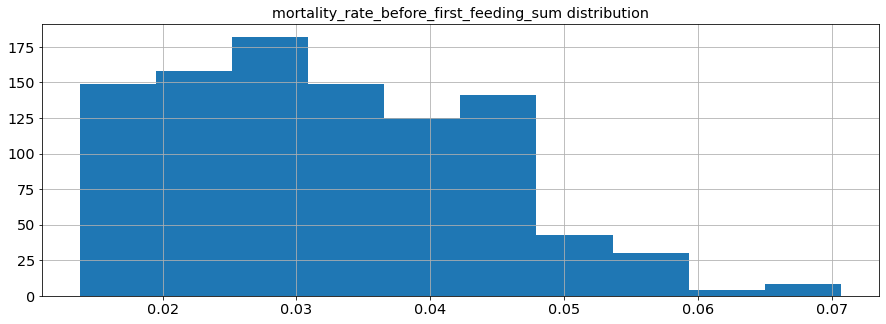

<Figure size 1080x360 with 0 Axes>

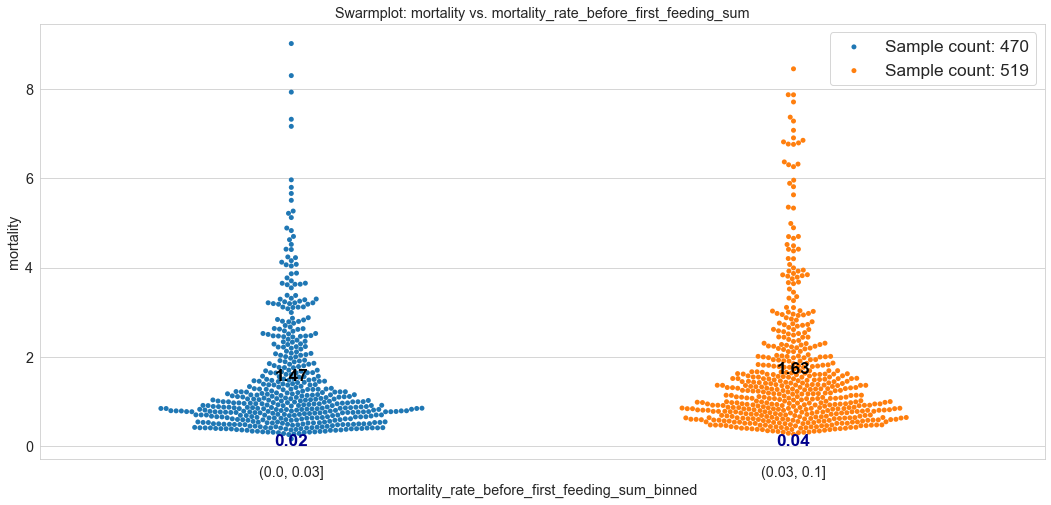

<Figure size 1080x360 with 0 Axes>

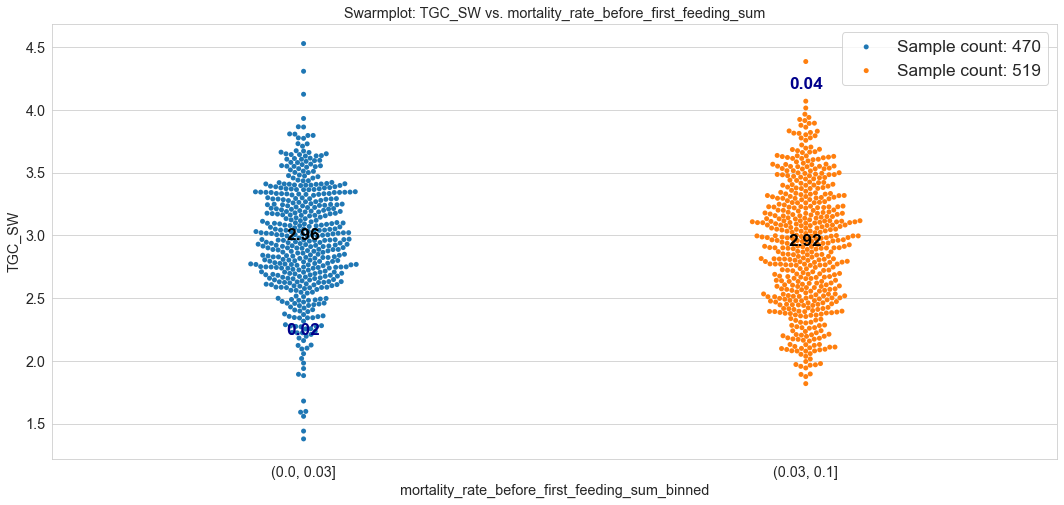

In [14]:
factor = 'mortality_rate_before_first_feeding_sum'

fw_mortality_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='mortality',
           bins=(0, 0.03, 0.1),
           y_scale=3)

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.03, 0.1),
           y_scale=0.01)

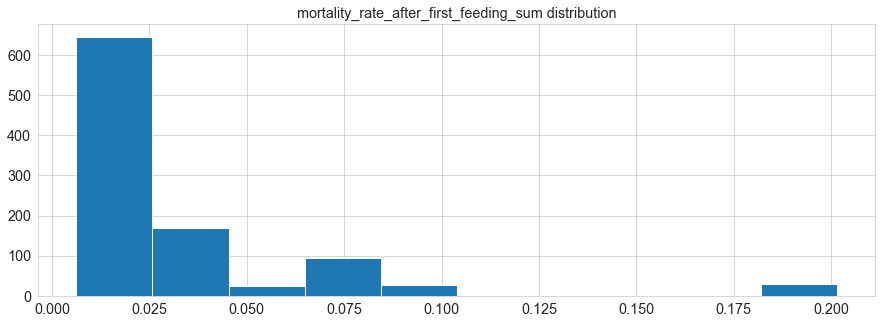

<Figure size 1080x360 with 0 Axes>

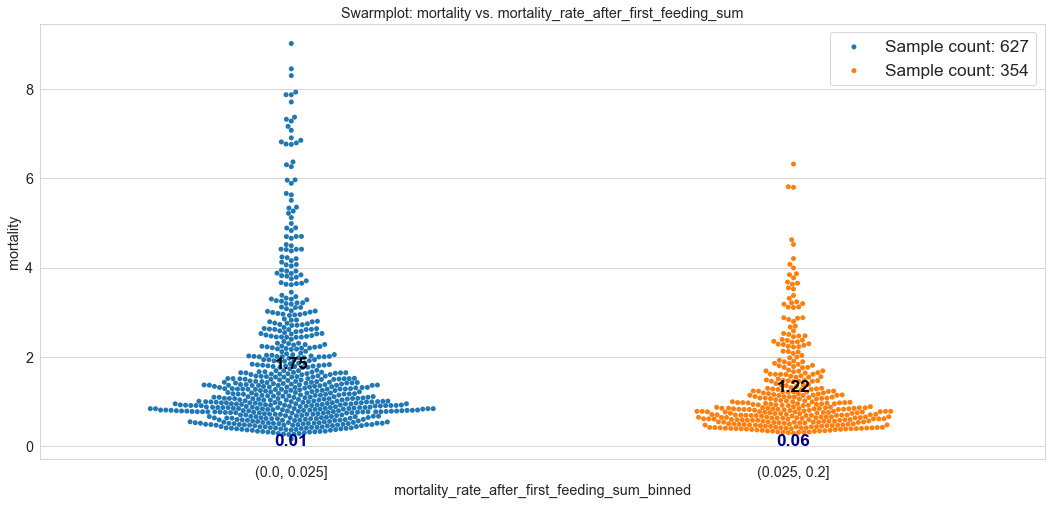

<Figure size 1080x360 with 0 Axes>

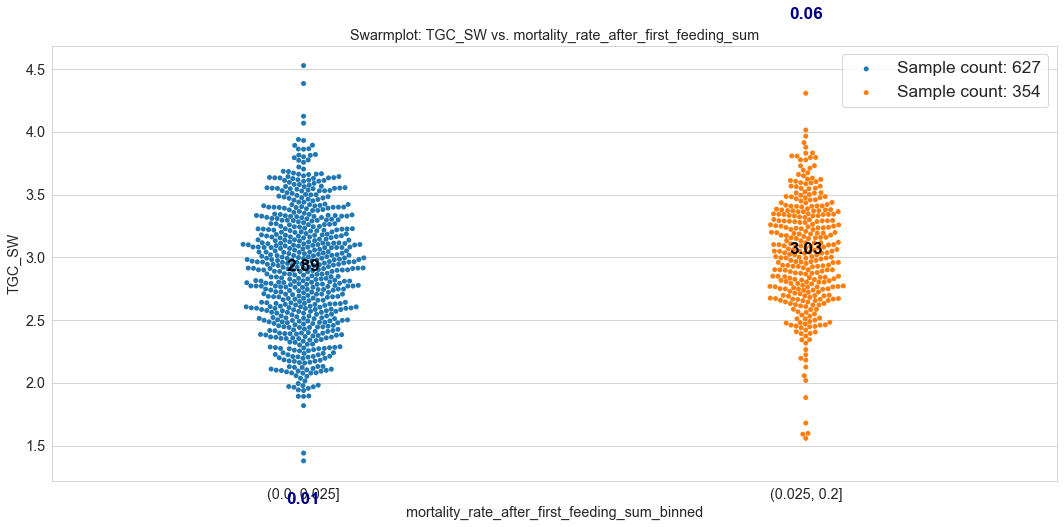

In [15]:
factor = 'mortality_rate_after_first_feeding_sum'

fw_mortality_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='mortality',
           bins=(0, 0.025, 0.2),
           y_scale=3)

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.025, 0.2),
           y_scale=0.012)

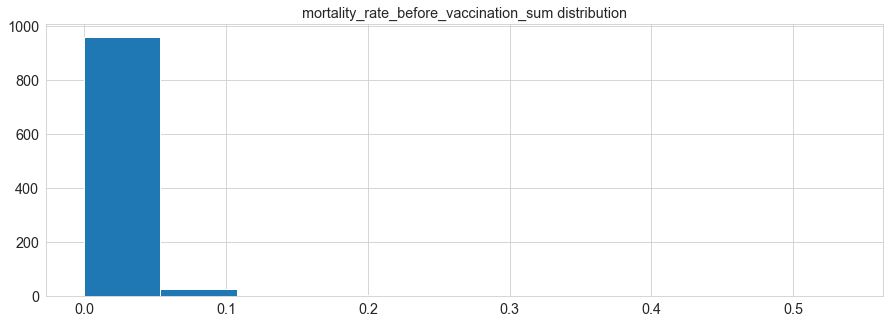

<Figure size 1080x360 with 0 Axes>

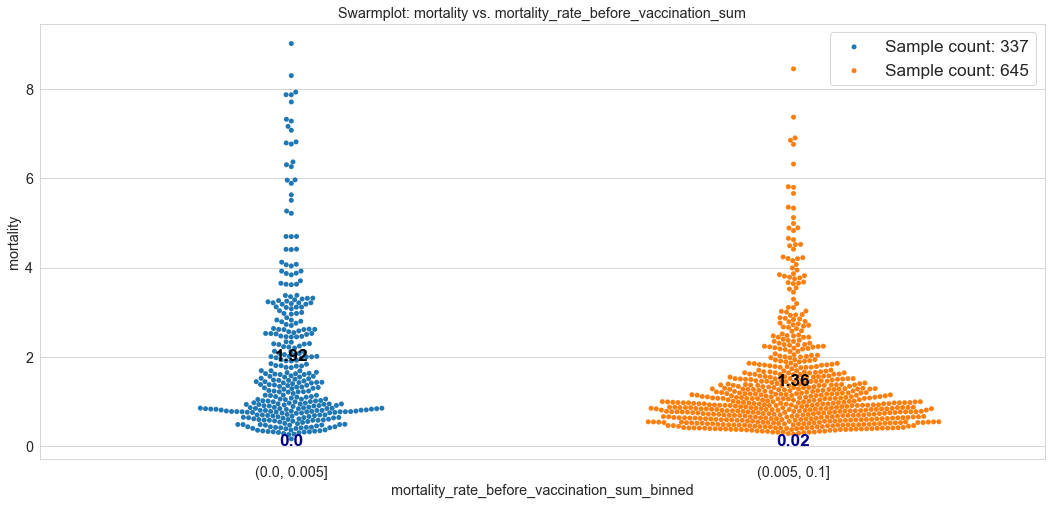

<Figure size 1080x360 with 0 Axes>

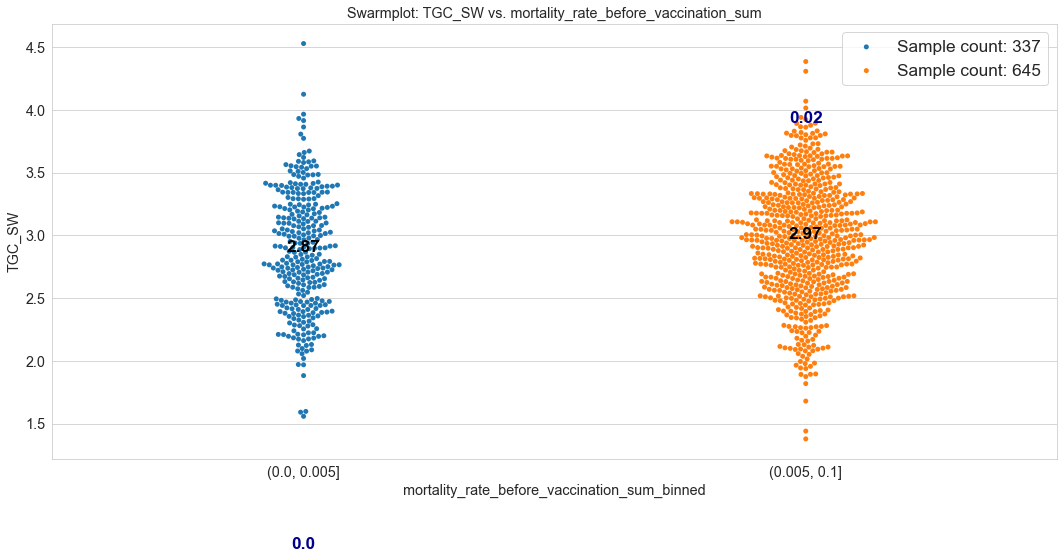

In [16]:
factor = 'mortality_rate_before_vaccination_sum'
fw_mortality_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='mortality',
           bins=(0, 0.005, 0.1),
           y_scale=3)

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.005, 0.1),
           y_scale=0.005)

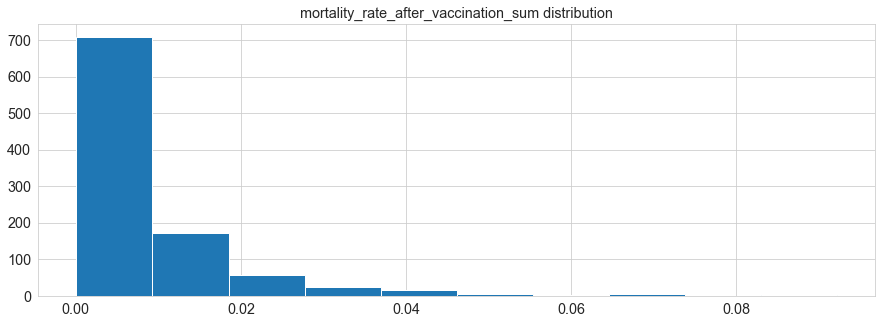

<Figure size 1080x360 with 0 Axes>

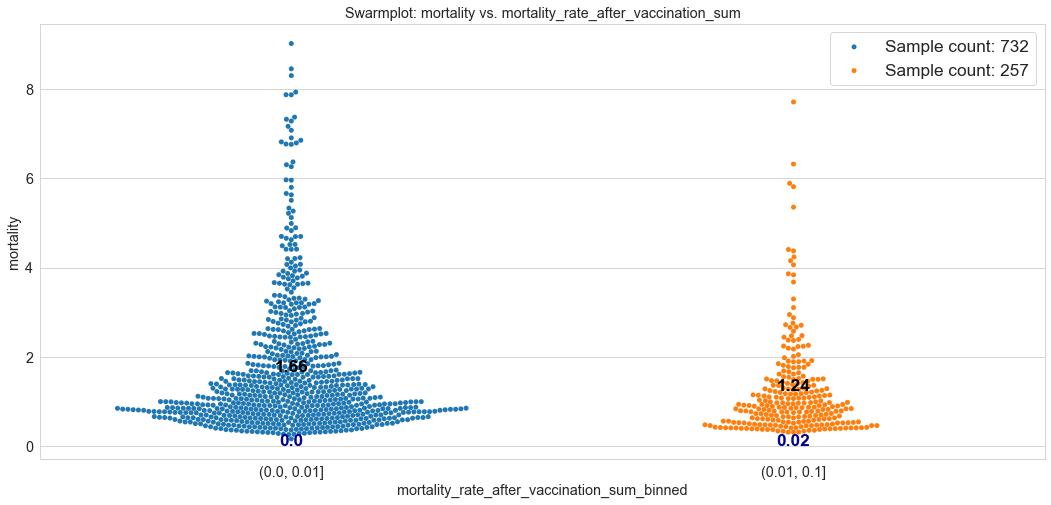

<Figure size 1080x360 with 0 Axes>

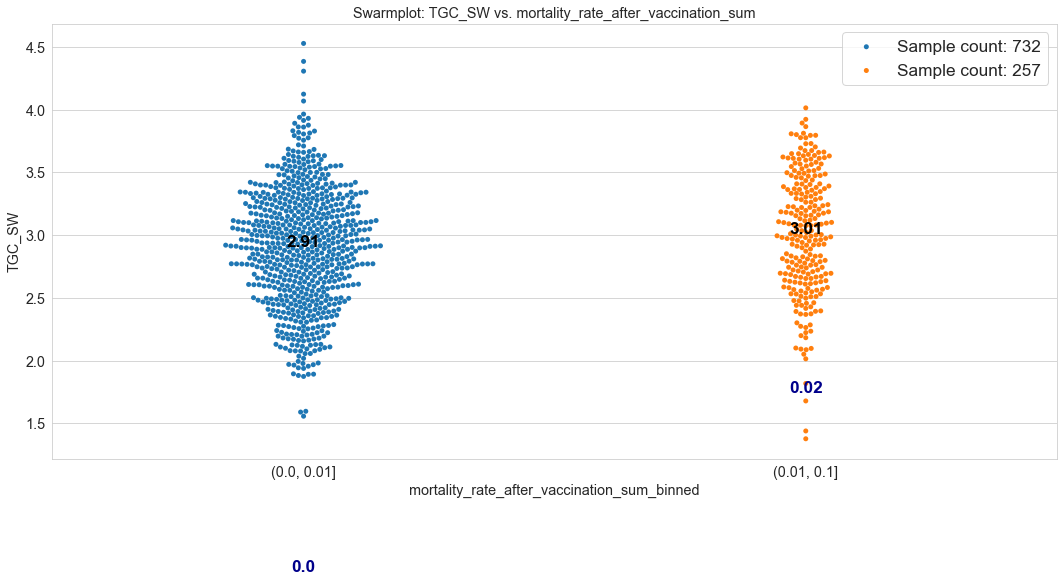

In [17]:
factor = 'mortality_rate_after_vaccination_sum'
fw_mortality_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='mortality',
           bins=(0, 0.01, 0.1),
           y_scale=3)

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.01, 0.1),
           y_scale=0.012)

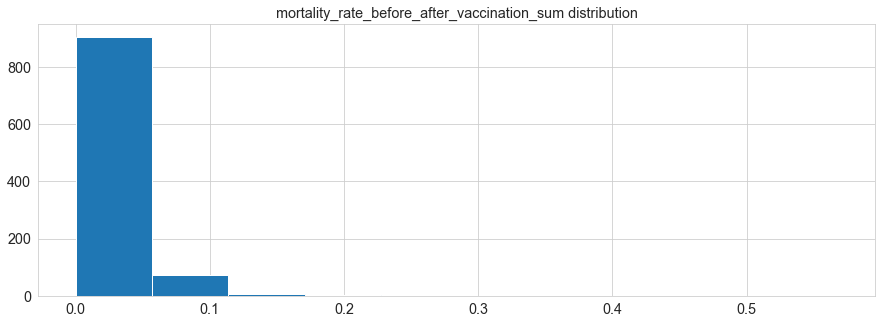

<Figure size 1080x360 with 0 Axes>

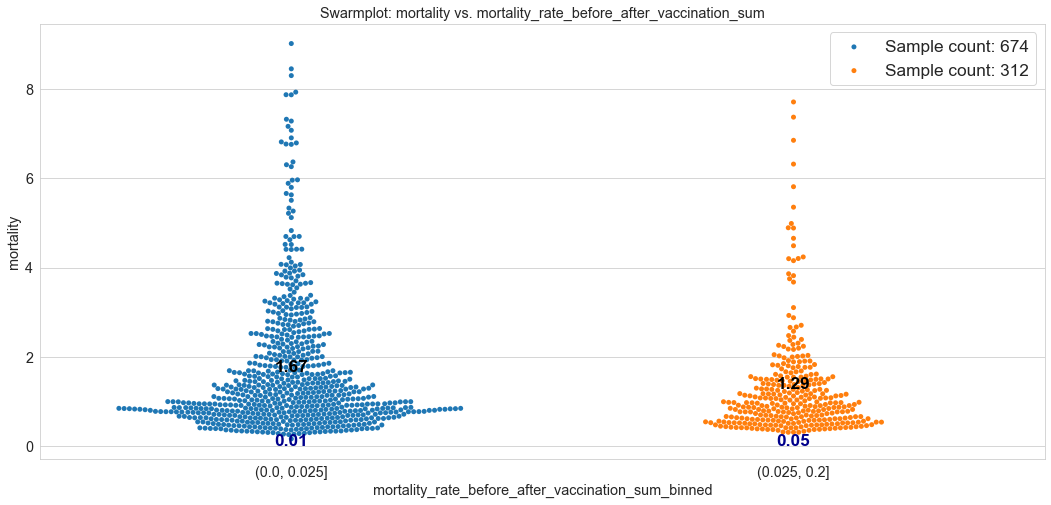

<Figure size 1080x360 with 0 Axes>

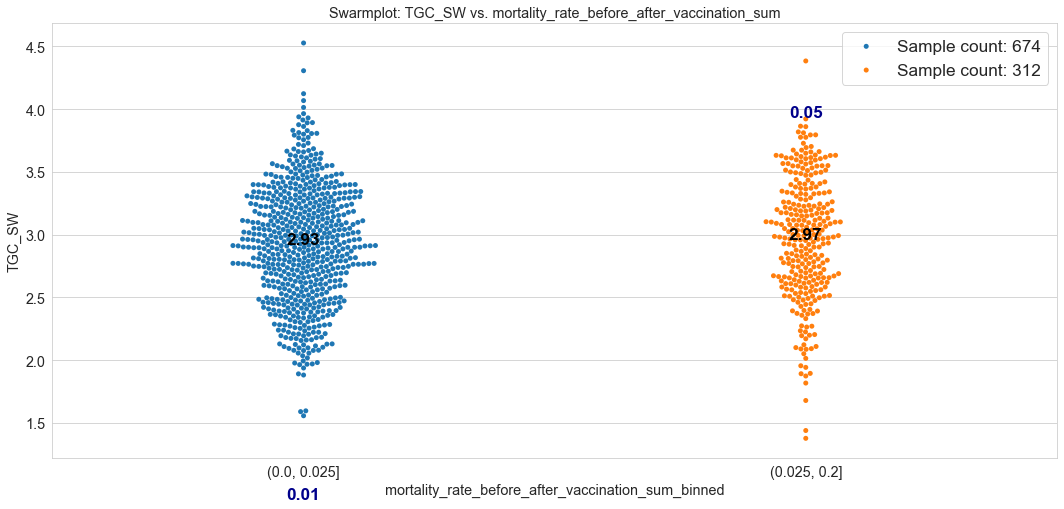

In [18]:
factor = 'mortality_rate_before_after_vaccination_sum'
fw_mortality_factors[factor].hist()
plt.title(f'{factor} distribution')
plt.show()

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='mortality',
           bins=(0, 0.025, 0.2),
           y_scale=3)

plot_swarm(fw_mortality_factors,
           factor=factor,
           target='TGC_SW',
           bins=(0, 0.025, 0.2),
           y_scale=0.012)